<a href="https://colab.research.google.com/github/RVijayChiranjithReddy/Fake_face_detection/blob/main/AMTEN_SEBLOCK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import tensorflow as tf
import keras
import cv2
from keras.models import Sequential
from tensorflow.keras import layers, models
from keras import Sequential,Model
from keras.layers import *
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D,UpSampling2D,Conv2DTranspose
import numpy as np
from cv2 import resize
from os import path, listdir
from keras.initializers import RandomNormal

In [ ]:
train_it = tf.keras.preprocessing.image_dataset_from_directory('/content/gdrive/MyDrive/Minor_project/split_data/train', batch_size=8, image_size=(128, 128))

val_it = tf.keras.preprocessing.image_dataset_from_directory('/content/gdrive/MyDrive/Minor_project/split_data/val', batch_size=8, image_size=(128, 128))

test_it = tf.keras.preprocessing.image_dataset_from_directory('/content/gdrive/MyDrive/Minor_project/split_data/test', batch_size=8, image_size=(128, 128))


Found 5364 files belonging to 2 classes.
Found 670 files belonging to 2 classes.
Found 673 files belonging to 2 classes.


In [ ]:
new_model = tf.keras.models.load_model('/content/gdrive/MyDrive/Minor_project/AMNET.h5')


In [ ]:
new_model.summary()

In [ ]:
new_model.trainable = False

In [ ]:

net = Model(inputs=new_model.input,outputs=new_model.layers[-5].output)


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_2


In [ ]:
from keras.engine import Layer, InputSpec
from keras import initializers, regularizers, constraints
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

import numpy as np


class InstanceNormalization(Layer):
    """Instance normalization layer (Lei Ba et al, 2016, Ulyanov et al., 2016).
    Normalize the activations of the previous layer at each step,
    i.e. applies a transformation that maintains the mean activation
    close to 0 and the activation standard deviation close to 1.
    # Arguments
        axis: Integer, the axis that should be normalized
            (typically the features axis).
            For instance, after a `Conv2D` layer with
            `data_format="channels_first"`,
            set `axis=1` in `InstanceNormalization`.
            Setting `axis=None` will normalize all values in each instance of the batch.
            Axis 0 is the batch dimension. `axis` cannot be set to 0 to avoid errors.
        epsilon: Small float added to variance to avoid dividing by zero.
        center: If True, add offset of `beta` to normalized tensor.
            If False, `beta` is ignored.
        scale: If True, multiply by `gamma`.
            If False, `gamma` is not used.
            When the next layer is linear (also e.g. `nn.relu`),
            this can be disabled since the scaling
            will be done by the next layer.
        beta_initializer: Initializer for the beta weight.
        gamma_initializer: Initializer for the gamma weight.
        beta_regularizer: Optional regularizer for the beta weight.
        gamma_regularizer: Optional regularizer for the gamma weight.
        beta_constraint: Optional constraint for the beta weight.
        gamma_constraint: Optional constraint for the gamma weight.
    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
    # Output shape
        Same shape as input.
    # References
        - [Layer Normalization](https://arxiv.org/abs/1607.06450)
        - [Instance Normalization: The Missing Ingredient for Fast Stylization](https://arxiv.org/abs/1607.08022)
    """
    def __init__(self,
                 axis=None,
                 epsilon=1e-3,
                 center=True,
                 scale=True,
                 beta_initializer='zeros',
                 gamma_initializer='ones',
                 beta_regularizer=None,
                 gamma_regularizer=None,
                 beta_constraint=None,
                 gamma_constraint=None,
                 **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.supports_masking = True
        self.axis = axis
        self.epsilon = epsilon
        self.center = center
        self.scale = scale
        self.beta_initializer = initializers.get(beta_initializer)
        self.gamma_initializer = initializers.get(gamma_initializer)
        self.beta_regularizer = regularizers.get(beta_regularizer)
        self.gamma_regularizer = regularizers.get(gamma_regularizer)
        self.beta_constraint = constraints.get(beta_constraint)
        self.gamma_constraint = constraints.get(gamma_constraint)

    def build(self, input_shape):
        ndim = len(input_shape)
        if self.axis == 0:
            raise ValueError('Axis cannot be zero')

        if (self.axis is not None) and (ndim == 2):
            raise ValueError('Cannot specify axis for rank 1 tensor')

        self.input_spec = InputSpec(ndim=ndim)

        if self.axis is None:
            shape = (1,)
        else:
            shape = (input_shape[self.axis],)

        if self.scale:
            self.gamma = self.add_weight(shape=shape,
                                         name='gamma',
                                         initializer=self.gamma_initializer,
                                         regularizer=self.gamma_regularizer,
                                         constraint=self.gamma_constraint)
        else:
            self.gamma = None
        if self.center:
            self.beta = self.add_weight(shape=shape,
                                        name='beta',
                                        initializer=self.beta_initializer,
                                        regularizer=self.beta_regularizer,
                                        constraint=self.beta_constraint)
        else:
            self.beta = None
        self.built = True

    def call(self, inputs, training=None):
        input_shape = K.int_shape(inputs)
        reduction_axes = list(range(0, len(input_shape)))

        if (self.axis is not None):
            del reduction_axes[self.axis]

        del reduction_axes[0]

        mean = K.mean(inputs, reduction_axes, keepdims=True)
        stddev = K.std(inputs, reduction_axes, keepdims=True) + self.epsilon
        normed = (inputs - mean) / stddev

        broadcast_shape = [1] * len(input_shape)
        if self.axis is not None:
            broadcast_shape[self.axis] = input_shape[self.axis]

        if self.scale:
            broadcast_gamma = K.reshape(self.gamma, broadcast_shape)
            normed = normed * broadcast_gamma
        if self.center:
            broadcast_beta = K.reshape(self.beta, broadcast_shape)
            normed = normed + broadcast_beta
        return normed

    def get_config(self):
        config = {
            'axis': self.axis,
            'epsilon': self.epsilon,
            'center': self.center,
            'scale': self.scale,
            'beta_initializer': initializers.serialize(self.beta_initializer),
            'gamma_initializer': initializers.serialize(self.gamma_initializer),
            'beta_regularizer': regularizers.serialize(self.beta_regularizer),
            'gamma_regularizer': regularizers.serialize(self.gamma_regularizer),
            'beta_constraint': constraints.serialize(self.beta_constraint),
            'gamma_constraint': constraints.serialize(self.gamma_constraint)
        }
        base_config = super(InstanceNormalization, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

get_custom_objects().update({'InstanceNormalization': InstanceNormalization})

In [ ]:
def __conv_init(a):
    print("conv_init", a)
    k = RandomNormal(0, 0.02)(a) # for convolution kernel
    k.conv_weight = True    
    return k
conv_init = RandomNormal(0, 0.02)
gamma_init = RandomNormal(1., 0.02) # for batch normalization
def instance_norm():
    return InstanceNormalization(axis=-1, epsilon=1.01e-5,
                                   gamma_initializer = gamma_init)

In [ ]:
    def se_block(input_tensor, compress_rate = 8):
        num_channels = int(input_tensor.shape[-1]) # Tensorflow backend
        bottle_neck = int(num_channels//compress_rate)

        se_branch = GlobalAveragePooling2D()(input_tensor)
        se_branch = Dense(bottle_neck, activation='relu')(se_branch)
        se_branch = Dense(num_channels, activation='sigmoid')(se_branch)

        x = input_tensor 
        out = multiply([x, se_branch])

        return out

In [ ]:
inputs = keras.Input(shape=(128, 128, 3))
x = net(inputs,training=False)
x1 = Conv2D(128,strides=1,kernel_size=3,padding="same")(x)
x1  = instance_norm()(x1, training=1)
x1 = LeakyReLU(alpha=0.2)(x1)
x1 = se_block(x1)
x = add([x,x1])
x = Flatten()(x)
x = Dense(300)(x)
x =  LeakyReLU(alpha=0.2)(x)
x = Dense(1,activation='sigmoid')(x)
model = tf.keras.Model(inputs=inputs, outputs=x)
model.summary()

In [ ]:
import math
initial_learning_rate = 0.001
def lr_step_decay(epoch, lr):
  drop_rate = 0.5
  epochs_drop = 5.0
  return initial_learning_rate * math.pow(drop_rate, math.floor(epoch/epochs_drop))

In [ ]:
opt = tf.keras.optimizers.SGD(learning_rate=0.1, momentum = 0.95, decay=0.005)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'], steps_per_execution = 1)
history = model.fit(train_it, validation_data=val_it, epochs=20, batch_size = 8, verbose=1, callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_step_decay, verbose=1)] )

Epoch 1/20

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
671/671 [==============================] - 1889s 3s/step - loss: 0.2080 - accuracy: 0.9117 - val_loss: 0.1109 - val_accuracy: 0.9507
Epoch 2/20

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
671/671 [==============================] - 196s 291ms/step - loss: 0.0555 - accuracy: 0.9835 - val_loss: 0.1104 - val_accuracy: 0.9567
Epoch 3/20

Epoch 00003: LearningRateScheduler reducing learning rate to 0.001.
671/671 [==============================] - 196s 292ms/step - loss: 0.0438 - accuracy: 0.9843 - val_loss: 0.1052 - val_accuracy: 0.9567
Epoch 4/20

Epoch 00004: LearningRateScheduler reducing learning rate to 0.001.
671/671 [==============================] - 196s 291ms/step - loss: 0.0365 - accuracy: 0.9901 - val_loss: 0.1032 - val_accuracy: 0.9582
Epoch 5/20

Epoch 00005: LearningRateScheduler reducing learning rate to 0.001.
671/671 [==============================] - 196s 292ms/step - l

In [ ]:
model.save('/content/drive/MyDrive/Minor_project/AMNET_se.h5')

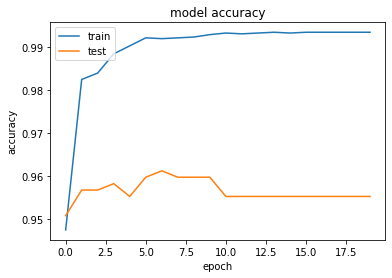

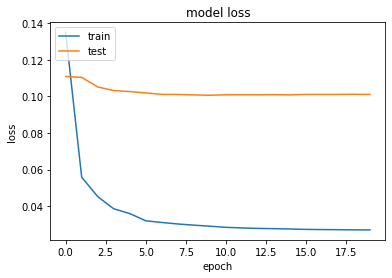

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.evaluate(test_it, batch_size=8, verbose=1)

85/85 [==============================] - 248s 3s/step - loss: 0.0886 - accuracy: 0.9614


[0.0885794460773468, 0.9613670110702515]

In [ ]:
nw_model = tf.keras.models.load_model('/content/AMNET.h5')


In [ ]:
from PIL import Image
from numpy import asarray
# load the image

im1 = Image.open(r'/content/testfake.PNG')
rgb_im = im1.convert('RGB')
image = rgb_im.resize((128,128))
# convert image to numpy array
data = asarray(image)
data = np.expand_dims(data, axis=0)
print(data.shape)

model.predict(data,batch_size=1)
#nw_model.predict(data,batch_size=1)

(1, 128, 128, 3)


array([[0.99990416]], dtype=float32)